# Testing the CNN approach

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
Image.LOAD_TRUNCATED_IMAGES=True
import sys
import random

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
cur_dir = os.getcwd()
data_path = os.path.relpath('../raw_data', cur_dir)
data_path

'../raw_data'

## 1 Wildfire images

### 1.1 Data preparation

#### The training data consists of around 15000 images of resolution 350x350.
#### For testing we consider a small batch of the data (set below with the parameter "reduction_factor")
#### We also reduce the resolution of the images (set by the resize_factor)

In [ ]:
def load_data(data_class : str, category : str, reduction_factor=10, resize_factor=10):
    """
    This function returns a list X of tensors of shape (350/resize_factor, 350/resize_factor, 3)
    and a list y of labels 0 (no wildfire) and 1 (wildfire)
    """
    X=[]
    y=[]

    path_to_data = os.path.join(data_path, 'satellite_images_2_classes', data_class, category)
    images = np.array(os.listdir(path_to_data))
    idx = np.random.choice(len(images), round(len(images)/reduction_factor), replace=False)
    images_small = images[idx]
    for files in images_small:
        file_path = os.path.join(path_to_data, files)
        img = Image.open(file_path)
        width, height = img.size
        img_low_res = img.resize((width//resize_factor, height//resize_factor))
        X.append(np.asarray(img_low_res, dtype='uint8'))
        if category == 'wildfire':
            y.append(1)
        else :
            y.append(0)

    return X, y

In [ ]:
def get_train_test(reduction_factor=10, resize_factor=10):
    """
    Function returns train, validation and test datasets
    """
    #X_train=[], y_train=[], X_val=[], y_val=[], X_test=[], y_test=[]

    X_train_wildfire, y_train_wildfire = load_data('train', 'wildfire', reduction_factor=reduction_factor, resize_factor=resize_factor)
    X_train_nowildfire, y_train_nowildfire = load_data('train', 'nowildfire', reduction_factor=reduction_factor, resize_factor=resize_factor)
    c = list(zip(X_train_wildfire+X_train_nowildfire, y_train_wildfire+y_train_nowildfire))
    np.random.shuffle(c)
    X_train, y_train = zip(*c)

    X_val_wildfire, y_val_wildfire = load_data('valid', 'wildfire', reduction_factor=reduction_factor, resize_factor=resize_factor)
    X_val_nowildfire, y_val_nowildfire = load_data('valid', 'nowildfire', reduction_factor=reduction_factor, resize_factor=resize_factor)
    c = list(zip(X_val_wildfire+X_val_nowildfire, y_val_wildfire+y_val_nowildfire))
    np.random.shuffle(c)
    X_val, y_val = zip(*c)

    X_test_wildfire, y_test_wildfire = load_data('test', 'wildfire', reduction_factor=reduction_factor, resize_factor=resize_factor)
    X_test_nowildfire, y_test_nowildfire = load_data('test', 'nowildfire', reduction_factor=reduction_factor, resize_factor=resize_factor)
    c = list(zip(X_test_wildfire+X_test_nowildfire, y_test_wildfire+y_test_nowildfire))
    np.random.shuffle(c)
    X_test, y_test = zip(*c)

    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), np.array(X_test), np.array(y_test)


#### Loading only 10% of the data and reducing the resolution by 7

In [29]:
X_train, y_train, X_val, y_val, X_test, y_test = get_train_test(reduction_factor=10, resize_factor=7)

#### Look at a random image

0


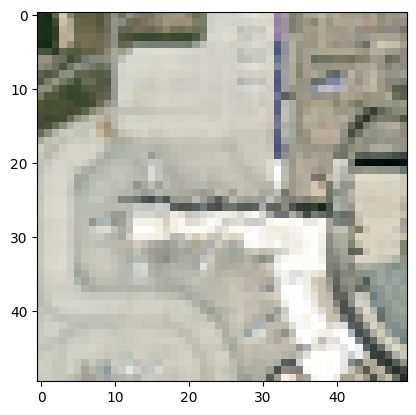

In [30]:
plt.imshow(X_train[10,:,:,:])
print(y_train[10])

In [31]:
print(f'Shape of X_train : {X_train.shape}')

Shape of X_train : (3025, 50, 50, 3)


#### Let's check for imbalance

In [34]:
print(f'fraction of wildfire images in train set : {len(y_train[y_train==1]) / len(y_train)}')
print(f'fraction of wildfire images in validation set : {len(y_val[y_val==1]) / len(y_val)}')
print(f'fraction of wildfire images in testing set : {len(y_test[y_test==1]) / len(y_test)}')

fraction of wildfire images in train set : 0.5206611570247934
fraction of wildfire images in validation set : 0.5523809523809524
fraction of wildfire images in testing set : 0.5523809523809524


#### Slight imbalance (Let's ignore for the moment)

### 1.2 Normalization

In [35]:
X_train_re = X_train/255
X_val_re = X_val/255
X_test_re = X_test/255

### 1.3 Building the model

In [36]:
from tensorflow.keras import layers, Sequential

def initialize_model():

    model = Sequential()

    model.add(layers.Conv2D(16, (4,4), activation='relu', input_shape=(X_train_re.shape[1],X_train_re.shape[2],X_train_re.shape[3])))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    #model.add(layers.Conv2D(32, (2,2), activation='relu'))
    #model.add(layers.MaxPool2D(pool_size=(2,2)))
    #model.add(layers.Conv2D(64, (3,3), activation='relu'))
    #model.add(layers.MaxPool2D(pool_size=(2,2)))
    #model.add(layers.Conv2D(64, (2,2), activation='relu'))
    #model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [37]:
model = initialize_model()

history = model.fit(X_train_re, y_train, validation_data=(X_val_re, y_val), epochs=10)

/home/bhupend/.pyenv/versions/3.10.6/envs/EnviroClass/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


2025-01-28 15:29:01.838510: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 90750000 exceeds 10% of free system memory.


95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5671 - loss: 0.6257 - val_accuracy: 0.9111 - val_loss: 0.2406
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8929 - loss: 0.2743 - val_accuracy: 0.8968 - val_loss: 0.2396
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9065 - loss: 0.2374 - val_accuracy: 0.8889 - val_loss: 0.2644
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9127 - loss: 0.2233 - val_accuracy: 0.9095 - val_loss: 0.2312
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9135 - loss: 0.2131 - val_accuracy: 0.9206 - val_loss: 0.2078
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9152 - loss: 0.2058 - val_accuracy: 0.9206 - val_loss: 0.2098
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9286 - loss: 0.1837 - val_accuracy: 0.9222 - val_loss: 0.2019
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9289 - loss: 0.1779 - val_accuracy: 0.9143 - val_loss: 0.

In [40]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS ---

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    #ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    #ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

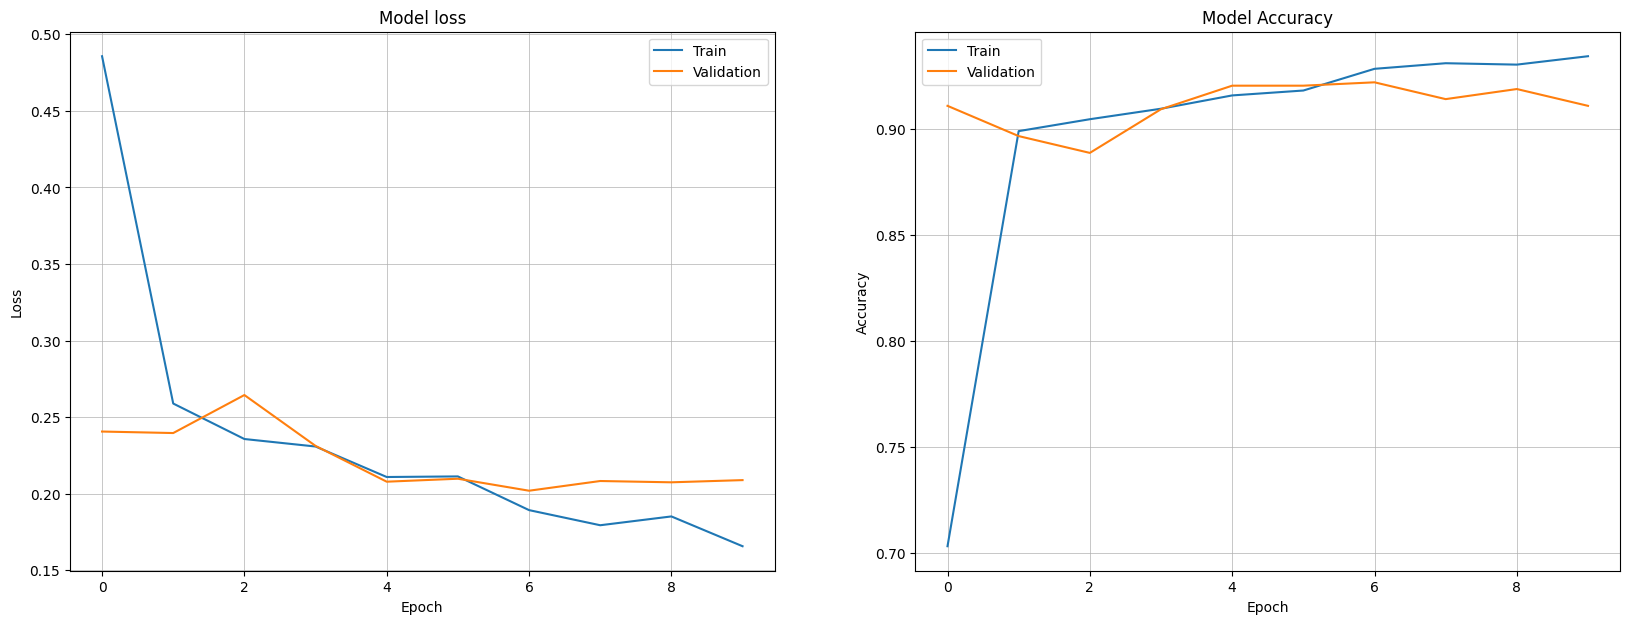

In [41]:
plot_loss_accuracy(history=history)

#### Evaluate the model on the test dataset

In [42]:
results = model.evaluate(X_test_re, y_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9300 - loss: 0.2421


## 2. Terrain dataset

### 2.1 Data preparation and preprocessing

#### Attention! Here we have inhomogeneous data. The data has -
#### 1) 256x256 RGB images (tensor of shape (256,256,3))
#### 2) 256x256 RGBA images (tensor of shape (256,256,4))
#### 3) 64x64 RGB images (tensor of shape (64,64,3))

#### To get a homogeneous data structure we rescale all image resolutions to 64x64 and drop the 4th channel as it is only for transperency (?)

In [4]:
def load_data_4_classes(reduction_factor=10):
    """
    Function returns X made up of tensors of shape (64,64,3)
    and labels y {'cloudy' : 0, 'desert' : 1, 'green_area' : 2, 'water' : 3}
    """
    labels = ['cloudy', 'desert', 'green_area', 'water']
    X=[]
    y=[]

    for label in labels:
        path_to_data = os.path.join(data_path, 'satellite_images_4_classes', label)
        images = np.array(os.listdir(path_to_data))
        idx = np.random.choice(len(images), round(len(images)/reduction_factor), replace=False)
        images_small = images[idx]
        for files in images_small:
            file_path = os.path.join(path_to_data, files)
            img = Image.open(file_path)
            width, height = img.size
            img_low_res = img
            if (width, height) == (256,256):
                img_low_res = img.resize((width//4, height//4))
            X.append(np.asarray(img_low_res, dtype='uint8')[:,:,:3])
            if label == 'cloudy':
                y.append(0)
            elif label == 'desert' :
                y.append(1)
            elif label == 'green_area' :
                y.append(2)
            else :
                y.append(3)

    c = list(zip(X, y))
    np.random.shuffle(c)
    X, y = zip(*c)

    return np.array(X), np.array(y)

#### Here we take the full dataset by setting reduction_factor to 1

In [5]:
X, y = load_data_4_classes(reduction_factor=1)

In [6]:
print(f'Shape of X : {X.shape}')

Shape of X : (5631, 64, 64, 3)


#### Checking again for imbalance

In [7]:
print(f'Fraction of class 0 : {len(y[y==0]) / len(y)}')
print(f'Fraction of class 1 : {len(y[y==1]) / len(y)}')
print(f'Fraction of class 2 : {len(y[y==2]) / len(y)}')
print(f'Fraction of class 3 : {len(y[y==3]) / len(y)}')

Fraction of class 0 : 0.2663825253063399
Fraction of class 1 : 0.20085242408098028
Fraction of class 2 : 0.2663825253063399
Fraction of class 3 : 0.2663825253063399


#### Slight imbalance in class 1. Ignore for now.

### Making the train test split

In [8]:
split_frac = 0.2

idx_test =  np.random.choice(X.shape[0], round(X.shape[0]*split_frac), replace=False)
idx_train = [i for i in range(X.shape[0]) if i not in idx_test]

In [9]:
X_train = X[idx_train]
labels_train = y[idx_train]
X_test = X[idx_test]
labels_test = y[idx_test]

In [10]:
X_train.shape

(4505, 64, 64, 3)

#### Normalization

In [11]:
X_train_rescaled = X_train/255
X_test_rescaled = X_test/255

#### One-hot encoding the labels

In [12]:
### Encoding the labels
from tensorflow.keras.utils import to_categorical

n_labels = len(set(y))

y_train = to_categorical(labels_train, n_labels)
y_test = to_categorical(labels_test, n_labels)

2025-01-29 11:54:12.246607: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-29 11:54:12.473470: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-29 11:54:12.673128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738148052.902159   31011 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738148052.949523   31011 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 11:54:13.517033: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### 1.2 Building the model

In [13]:
from tensorflow.keras import layers, Sequential

def initialize_model():

    model = Sequential()

    model.add(layers.Conv2D(16, (4,4), activation='relu', input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### Second Convolution & MaxPooling
    model.add(layers.Conv2D(32, kernel_size=(4,4), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(5,5), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #model.add(layers.Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
    #model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### Flattening
    model.add(layers.Flatten())

    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))

    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(layers.Dense(n_labels, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [14]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [15]:
model = initialize_model()
model.summary()

/home/bhupend/.pyenv/versions/3.10.6/envs/EnviroClass/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-29 11:54:32.072515: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 61, 61, 16)     │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        50,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,804 (432.83 KB)

 Trainable params: 110,804 (432.83 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(X_train_rescaled, y_train, validation_split=0.2, epochs=10)

Epoch 1/10


2025-01-29 11:54:35.331649: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 177143808 exceeds 10% of free system memory.


113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 179ms/step - accuracy: 0.5176 - loss: 1.0456 - val_accuracy: 0.7725 - val_loss: 0.6517
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.6844 - loss: 0.6988 - val_accuracy: 0.7647 - val_loss: 0.5137
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.7847 - loss: 0.4601 - val_accuracy: 0.7137 - val_loss: 0.5402
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 265ms/step - accuracy: 0.7534 - loss: 0.4825 - val_accuracy: 0.8013 - val_loss: 0.4376
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 201ms/step - accuracy: 0.8583 - loss: 0.3682 - val_accuracy: 0.8579 - val_loss: 0.3882
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.8518 - loss: 0.3822 - val_accuracy: 0.8413 - val_loss: 0.3673
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 171ms/step - accuracy: 0.8630 - loss: 0.3302 - val_accuracy: 0.8579 - val_loss: 0.3386
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.8405 - loss: 0.3811 - val

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

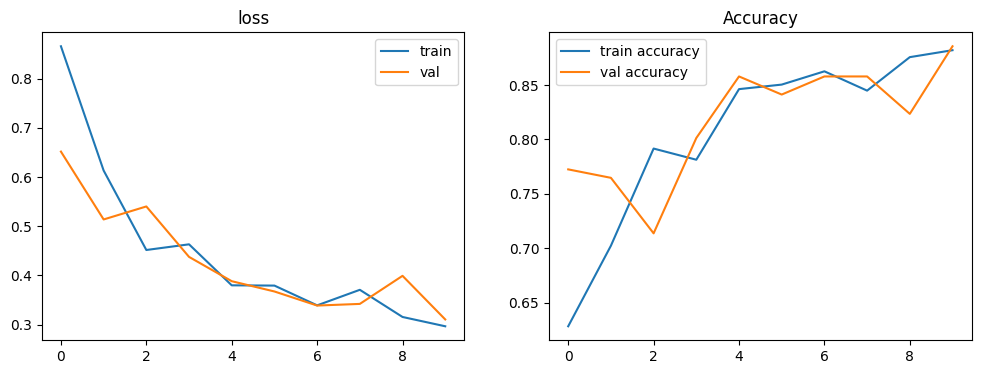

In [17]:
plot_history(history=history)

## 3. Structures dataset

In [3]:
def load_data(data_class : str, reduction_factor=10, resize_factor=10):
    X=[]
    y=[]

    path_to_data = os.path.join(data_path, 'satellite_images_14_classes', data_class, 'images')
    path_to_labels = os.path.join(data_path, 'satellite_images_14_classes', data_class, 'labels')
    images = np.array(os.listdir(path_to_data))
    labels = np.array(os.listdir(path_to_labels))
    idx = np.random.choice(len(images), round(len(images)/reduction_factor), replace=False)
    images_small = images[idx]
    labels_small = labels[idx]
    for file, label in zip(images_small, labels_small):
        file_path = os.path.join(path_to_data, file)
        label_path = os.path.join(path_to_labels, label)
        img = Image.open(file_path)
        width, height = img.size
        img_low_res = img.resize((width//resize_factor, height//resize_factor))
        label_vector = np.zeros(10)
        with open(label_path) as f:
            for line in f:
                lab = int(line[0])
                label_vector[lab] = 1
        image = np.asarray(img_low_res, dtype='uint8')
        y.append(label_vector)
        X.append(image)

    return np.array(X), np.array(y)


In [26]:
X_train, labels_train = load_data('train', reduction_factor=1, resize_factor=10)
X_val, labels_val = load_data('valid', reduction_factor=1, resize_factor=10)
X_test, labels_test = load_data('test', reduction_factor=1, resize_factor=10)

In [138]:
X_train_norm = X_train/255
X_val_norm = X_val/255
X_test_norm = X_test/255

In [158]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import RMSprop

rmsprop = RMSprop(momentum=0.2)

def initialize_model():

    model = Sequential()

    model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])))
    #model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    #model.add(layers.Dropout(0.2))

    ### Second Convolution & MaxPooling
    model.add(layers.Conv2D(32, kernel_size=(5,5), activation='relu', padding='same'))
    #model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    #model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(64, kernel_size=(5,5), activation='relu', padding='same'))
    #model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    #model.add(layers.Dropout(0.2))

    #model.add(layers.Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
    #model.add(layers.BatchNormalization())
    #model.add(layers.MaxPool2D(pool_size=(2,2)))
    #model.add(layers.Dropout(0.2))

    ### Flattening
    model.add(layers.Flatten())

    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))

    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(layers.Dense(10, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [159]:
model = initialize_model()
model.summary()

/home/bhupend/.pyenv/versions/3.10.6/envs/EnviroClass/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_116 (Conv2D)             │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_116               │ (None, 31, 31, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_117 (Conv2D)             │ (None, 31, 31, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_117               │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ (None, 15, 15, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_118               │ (None, 7, 7, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_37 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 16)             │        50,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,178 (449.91 KB)

 Trainable params: 115,178 (449.91 KB)

 Non-trainable params: 0 (0.00 B)

In [160]:
history = model.fit(X_train_norm, labels_train, validation_data=(X_val_norm, labels_val), epochs=20)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - accuracy: 0.0784 - loss: 0.6421 - val_accuracy: 0.0500 - val_loss: 0.5730
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 306ms/step - accuracy: 0.0779 - loss: 0.5443 - val_accuracy: 0.0500 - val_loss: 0.4936
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.0515 - loss: 0.4754 - val_accuracy: 0.0500 - val_loss: 0.4354
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.1424 - loss: 0.4235 - val_accuracy: 0.3050 - val_loss: 0.3824
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.2968 - loss: 0.3798 - val_accuracy: 0.3050 - val_loss: 0.3731
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.3178 - loss: 0.3645 - val_accuracy: 0.3050 - val_loss: 0.3548
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - accuracy: 0.3531 - loss: 0.3443 - val_accuracy: 0.3050 - val_loss: 0.3500
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.3004 - loss: 0.3501 - val_accuracy: 0

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

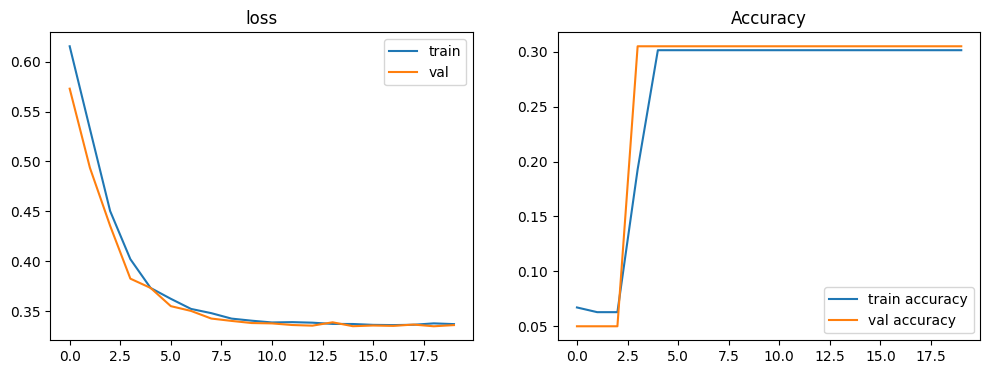

In [161]:
plot_history(history)

In [162]:
model.predict(X_test_norm[:2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


array([[0.06105973, 0.27869645, 0.05084078, 0.15761082, 0.07101528,
        0.08469114, 0.08013929, 0.04593236, 0.05804928, 0.05263209],
       [0.05043063, 0.26462418, 0.04198544, 0.14288129, 0.06014369,
        0.07373412, 0.0698244 , 0.03722476, 0.04713487, 0.04284947]],
      dtype=float32)

In [157]:
labels_test[:2]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])